In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
from os.path import join
import os

In [2]:
train = sc.read_h5ad("/hpc/mydata/rowan.cassius/data/scGPT/annotation_pancreas/demo_train.h5ad")

In [3]:
test = sc.read_h5ad("/hpc/mydata/rowan.cassius/data/scGPT/annotation_pancreas/demo_test.h5ad")

In [4]:
SET = "set"
train.obs[SET] = "train"
test.obs[SET] = "test"

In [18]:
import anndata as ad
adata = ad.concat([train, test], join='outer', axis=0)

In [6]:
CELL_TYPE = "cell_type"

In [28]:
adata.obs = adata.obs.rename({"Celltype": "cell_type"}, axis=1, copy=True)

In [8]:
adata.obs

,cell_type,set
human1_lib1.final_cell_0001,acinar,train
human1_lib1.final_cell_0003,acinar,train
human1_lib1.final_cell_0004,acinar,train
human1_lib1.final_cell_0005,acinar,train
human1_lib1.final_cell_0006,acinar,train
...,...,...
Sample_1594,PP,test
Sample_1595,PP,test
Sample_1597,PP,test
Sample_1598,PP,test


In [9]:
cell_types = adata.obs["cell_type"].unique().tolist()
cell_types

['acinar',
 'delta',
 'beta',
 'PSC',
 'alpha',
 'ductal',
 'epsilon',
 'PP',
 'endothelial',
 'macrophage',
 'schwann',
 'mast',
 't_cell',
 'MHC class II']

In [10]:
cell_type_dir = "/hpc/mydata/rowan.cassius/data/scGPT/annotation_pancreas/cell_type"

In [11]:
adata.obs["cell_type"].value_counts(ascending=False)

cell_type
alpha           5147
beta            3972
ductal          1704
acinar          1353
delta            981
PP               638
PSC              597
endothelial      289
macrophage        52
mast              32
epsilon           28
schwann           13
t_cell             7
MHC class II       5
Name: count, dtype: int64

In [ ]:
# counts = sc.AnnData(X=adata.X, obs=adata.obs)
# counts.var_names = adata.var_names
# counts.X = np.expm1(adata.X)
# adata = counts
# adata.var["ensembl_id"] = adata.var_names.map(hugo_to_ensg)
# adata = adata[:,~adata.var["ensembl_id"].isna()]
# adata.var.set_index("ensembl_id", inplace=True)

In [ ]:
# adata.raw = adata
# sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.log1p(adata)

In [21]:
adata.X

array([[0.       , 0.       , 1.5727894, ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 1.1705312, ..., 0.       , 0.       ,
        0.       ],
       [0.7407242, 0.       , 1.1615583, ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 7.3186674, ..., 0.3575595, 0.       ,
        0.       ],
       [0.       , 0.       , 5.9642696, ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 8.607396 , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

In [15]:
adata.obs["cell_type"].value_counts(ascending=False).index.tolist()

['alpha',
 'beta',
 'ductal',
 'acinar',
 'delta',
 'PP',
 'PSC',
 'endothelial',
 'macrophage',
 'mast',
 'epsilon',
 'schwann',
 't_cell',
 'MHC class II']

In [ ]:
# for cell_type in cell_types:
#     type_dir = join(cell_type_dir, cell_type, "partitions")
#     os.makedirs(type_dir, exist_ok=True)
#     partition = adata[adata.obs[CELL_TYPE] == cell_type, :]
#     print(f"Detected {partition.shape[0]:,} cells in partition: {cell_type}...")

#     write_path = join(type_dir, "partition_0.h5ad")
#     partition.write_h5ad(write_path)

In [14]:
adata

AnnData object with n_obs × n_vars = 14818 × 3000
    obs: 'cell_type', 'set'
    obsm: 'X_umap'

In [22]:
import scanpy as sc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [23]:
sc.tl.pca(adata, svd_solver='arpack', random_state=12345)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

In [27]:
adata

AnnData object with n_obs × n_vars = 14818 × 3000
    obs: 'Celltype', 'set'
    uns: 'log1p', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

Text(0.5, 1.0, 'Human Immune Cells Dataset')

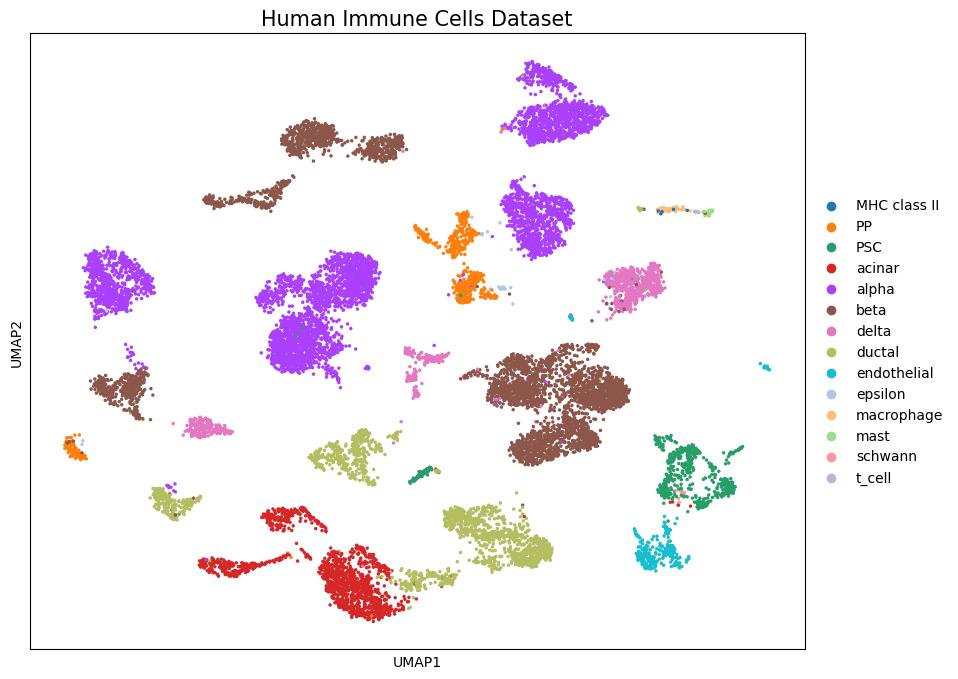

In [29]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 8))
sc.pl.umap(adata, color=CELL_TYPE, ax=ax, size=25, show=False)
ax.set_title("Human Immune Cells Dataset", fontsize=15)

Text(0.5, 1.0, 'Human Immune Cells Dataset')

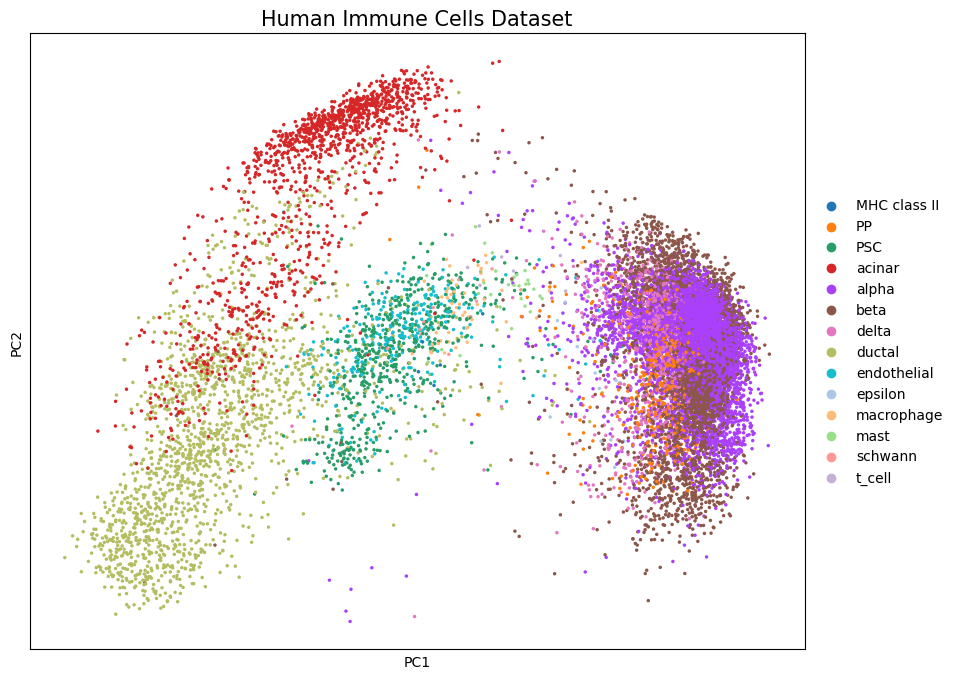

In [31]:
fig, ax = plt.subplots(figsize=(10, 8))
sc.pl.pca(adata, color=CELL_TYPE, ax=ax, size=25, show=False)
ax.set_title("Human Immune Cells Dataset", fontsize=15)

In [32]:
train = adata[adata.obs["set"] == "train",:]
test = adata[adata.obs["set"] == "test",:]

In [34]:
X_train = train.obsm["X_pca"]
y_train = train.obs[CELL_TYPE]
X_test = test.obsm["X_pca"]
y_test = test.obs[CELL_TYPE]

knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))

pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T

Accuracy: 0.9689426268373637


/hpc/mydata/rowan.cassius/anaconda/23.1.0-3/x86_64/envs/scllm/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/hpc/mydata/rowan.cassius/anaconda/23.1.0-3/x86_64/envs/scllm/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/hpc/mydata/rowan.cassius/anaconda/23.1.0-3/x86_64/envs/scllm/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to con

,precision,recall,f1-score,support
MHC class II,0.000000,0.000000,0.000000,5.000000
PP,0.996441,0.992908,0.994671,282.000000
PSC,1.000000,0.945205,0.971831,73.000000
acinar,1.000000,0.545455,0.705882,209.000000
alpha,0.996026,0.997016,0.996521,2011.000000
beta,0.995996,0.989066,0.992519,1006.000000
delta,0.989189,0.973404,0.981233,188.000000
ductal,0.809430,0.995169,0.892741,414.000000
endothelial,0.695652,1.000000,0.820513,16.000000
epsilon,0.857143,0.857143,0.857143,7.000000
